In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from xgboost import XGBRegressor



from statsmodels.tsa.deterministic import DeterministicProcess

print('hello world')

hello world


c:\Users\Admin\anaconda3\envs\KHS_pytorch_v1.8.2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_origin = pd.read_csv('open/train.csv')

train_df = pd.read_csv('open/train.csv')
test_df = pd.read_csv('open/test.csv')
sub_df = pd.read_csv('open/sample_submission.csv')

print('Number of Data for training : {col}\n Number of Variables : {row}'
      .format(col = train_df.shape[0], row = train_df.shape[1]))

Number of Data for training : 1095
 Number of Variables : 13


주말 / 평일 구분 (Column : days_of_week)

In [3]:
train_df.loc[[611,612,613,614,615]] # 2019-09-07 자료가 없어...

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
611,2019-09-04,22.7,22.8,25.5,21.2,6.0,3.0,89.0,1.1,8.5,2.5,4.5,27168
612,2019-09-05,36.4,23.0,27.6,21.5,9.0,6.0,91.4,1.5,11.6,2.0,5.0,33929
613,2019-09-06,2.4,25.3,29.1,21.6,13.0,8.0,79.8,0.4,3.1,2.1,3.4,16631
614,2019-09-08,0.0,24.7,27.3,22.9,NaN,NaN,76.9,1.4,11.0,1.9,4.8,52055
615,2019-09-09,0.0,25.1,28.0,22.4,35.0,26.0,74.3,2.0,15.7,1.7,3.6,68370


In [4]:
# 2018.01.01 ~ 2020.12.31 (NaN of 2019.09.07 sat ;;;;;)
# 
new_row = pd.DataFrame(train_df.loc[[613]], columns = train_df.columns)

train_df = pd.concat([train_df.iloc[:613], new_row, train_df.iloc[613:]], ignore_index = True)

train_df.loc[614,'date'] = '2019-09-07' 


print(train_df.loc[[612,613,614,615]])
len(train_df)

           date  precipitation  temp_mean  temp_highest  temp_lowest  PM10  \
612  2019-09-05           36.4       23.0          27.6         21.5   9.0   
613  2019-09-06            2.4       25.3          29.1         21.6  13.0   
614  2019-09-07            2.4       25.3          29.1         21.6  13.0   
615  2019-09-08            0.0       24.7          27.3         22.9   NaN   

     PM2.5  humidity  sunshine_sum  sunshine_rate  wind_mean  wind_max  rental  
612    6.0      91.4           1.5           11.6        2.0       5.0   33929  
613    8.0      79.8           0.4            3.1        2.1       3.4   16631  
614    8.0      79.8           0.4            3.1        2.1       3.4   16631  
615    NaN      76.9           1.4           11.0        1.9       4.8   52055  


1096

In [5]:
# To distinguish weekend and weekday

# The name of new index is "days_of_week" 
# [0:Mon ~ Fri, 1:Sat, 1:Sun]

df_week = [] # List for df column "days of week"

L1 = train_df.shape[0] // 7  # 1096 // 7
L2 = train_df.shape[0] % 7  # 1096 // 7

#week = [0, 1, 2, 3, 4, 5, 6]
week = [0, 0, 0, 0, 0, 1, 1] # weekday / weekend

for i in range(0,L1,1):
    df_week.extend(week)

for i in range(0,L2,1):
    df_week.append(0)

print(len(df_week))


# test_df
t_df_week = []

t_L1 = test_df.shape[0] // 7
t_L2 = test_df.shape[0] % 7

t_week = [0, 1, 1, 0, 0, 0, 0]

for i in range(0, t_L1, 1):
    t_df_week.extend(week)

for i in range(0, t_L2, 1):
    t_df_week.append(0)

1096


In [6]:
# Appended New Col "days of week"
train_df['days_of_week'] = df_week

test_df['days_of_week'] = t_df_week

코드공유에서 가져온 Year / Month / Day 구분

In [7]:
year = []
month = []
day = [] 

for date in train_df["date"] :
    y = date.split('-')[0]
    m = date.split('-')[1]
    d = date.split('-')[2]
    
    year.append(y)
    month.append(m)
    day.append(d)

train_df["year"] = year 
train_df["month"] = month 
train_df["day"] = day

year = []
month = []
day = [] 

for date in test_df["date"] :
    y = date.split('-')[0]
    m = date.split('-')[1]
    d = date.split('-')[2]
    
    year.append(y)
    month.append(m)
    day.append(d)

test_df["year"] = year 
test_df["month"] = month 
test_df["day"] = day

train_df['year'] = pd.to_numeric(train_df['year'])
train_df['month'] = pd.to_numeric(train_df['month'])
train_df['day'] = pd.to_numeric(train_df['day'])

test_df['year'] = pd.to_numeric(test_df['year'])
test_df['month'] = pd.to_numeric(test_df['month'])
test_df['day'] = pd.to_numeric(test_df['day'])

In [8]:
train_df

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,days_of_week,year,month,day
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,0,2018,1,1
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,0,2018,1,2
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,0,2018,1,3
3,2018-01-04,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,0,2018,1,4
4,2018-01-05,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,0,2018,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,0.0,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103,1,2020,12,27
1092,2020-12-28,1.3,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912,0,2020,12,28
1093,2020-12-29,0.2,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747,0,2020,12,29
1094,2020-12-30,NaN,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488,0,2020,12,30


In [9]:
test_df

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,days_of_week,year,month,day
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1,0,2021,1,1
1,2021-01-02,NaN,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4,0,2021,1,2
2,2021-01-03,NaN,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5,0,2021,1,3
3,2021-01-04,0.0,-3.5,0.3,-8.4,40.0,23.0,51.4,4.6,47.4,1.7,3.2,0,2021,1,4
4,2021-01-05,0.0,-5.5,-2.1,-9.9,30.0,17.0,52.8,8.6,88.7,2.9,5.7,0,2021,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,0.0,-7.6,-3.9,-12.9,33.0,20.0,60.9,3.8,39.6,1.7,3.1,0,2021,12,27
361,2021-12-28,NaN,-4.1,-0.9,-8.5,51.0,38.0,73.8,1.7,17.7,2.2,3.1,0,2021,12,28
362,2021-12-29,0.2,0.4,5.9,-3.8,66.0,49.0,72.9,1.8,18.8,2.6,5.9,1,2021,12,29
363,2021-12-30,0.0,-3.9,0.2,-6.8,30.0,17.0,48.5,7.3,76.0,3.3,6.6,1,2021,12,30


Sunshine_rate을 이용하여 Sunshine_sum의 NaN을 선형 회귀로 구하기

In [10]:
nan_list_ss = train_df['sunshine_sum'][train_df['sunshine_sum'].isnull()].index
print(nan_list_ss)

t_nan_list_ss = test_df['sunshine_sum'][test_df['sunshine_sum'].isnull()].index
print(t_nan_list_ss)

Int64Index([17, 25, 45, 187, 604], dtype='int64')
Int64Index([6], dtype='int64')


In [11]:
train_df['sunshine_rate'].loc[nan_list_ss].values.reshape(-1,1) 
# 사실 train 데이터에서는 sunshine_sum이 Nan인 날은 전부 sunshine_rate가 0이라 걍 0으로 채워도 될거같음
# 그리고 test 데이터는 sunshine_sum Nan이 하나밖에없어서 큰 영향을 안줄듯
# 근데 이미 다 작성해놔서 걍 안지우고 넣어둠 ㅎㅎ..

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

               sunshine_rate  sunshine_sum
sunshine_rate       1.000000      0.958364
sunshine_sum        0.958364      1.000000


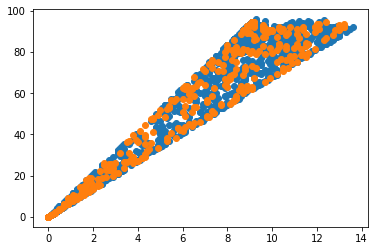

In [12]:
print(train_df[['sunshine_rate', 'sunshine_sum']].corr(method='pearson')) # Pearson Correlation

a = train_df['sunshine_sum'].dropna()
b = train_df['sunshine_rate'].drop(nan_list_ss)
a.isnull().sum()
b.isnull().sum()

t_a = test_df['sunshine_sum'].dropna()
t_b = test_df['sunshine_rate'].drop(t_nan_list_ss)
t_a.isnull().sum()
t_b.isnull().sum()

plt.plot(a,b, 'o')
plt.plot(t_a,t_b, 'o')

In [13]:
a = a.values.reshape(-1,1) # a is sunshine_sum
b = b.values.reshape(-1,1) # b is sunshine_rate

t_a = t_a.values.reshape(-1, 1)
t_b = t_b.values.reshape(-1, 1)

In [14]:
line_fitter = LinearRegression() # 선형회귀 이용하여 SS의 Nan 값 예측

line_fitter.fit(b, a) # predict a(sum) through b(rate) 
pred_ss = line_fitter.predict(train_df['sunshine_rate'].loc[nan_list_ss].values.reshape(-1, 1))
predd_ss = list(pred_ss)

t_pred_ss = line_fitter.predict(test_df['sunshine_rate'].loc[t_nan_list_ss].values.reshape(-1, 1))
t_pred_ss = list(t_pred_ss)

In [15]:
train_df["PM10"] = train_df["PM10"].fillna(train_df["PM10"].mean())
train_df["PM2.5"] = train_df["PM2.5"].fillna(train_df["PM2.5"].mean())
train_df["sunshine_sum"] = train_df["sunshine_sum"].fillna(0) # NaN값은  = 2  << 이런식으로 안들어가서
# 일단 0으로 다 채운다음에 선형회귀로 구한 값 입력

for i, j in zip(nan_list_ss, range(0,len(nan_list_ss),1)):
    train_df['sunshine_sum'].loc[i] = float(pred_ss[j])

for ii, jj in zip(t_nan_list_ss, range(0, len(t_nan_list_ss), 1)):
    test_df['sunshine_sum'].loc[ii] = float(t_pred_ss[jj])


C:\Users\Admin\AppData\Local\Temp/ipykernel_17000/2537484416.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sunshine_sum'].loc[i] = float(pred_ss[j])
C:\Users\Admin\AppData\Local\Temp/ipykernel_17000/2537484416.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sunshine_sum'].loc[ii] = float(t_pred_ss[jj])


In [16]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

date               0
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       0
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
days_of_week       0
year               0
month              0
day                0
dtype: int64
date               0
precipitation    205
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       0
sunshine_rate      0
wind_mean          0
wind_max           0
days_of_week       0
year               0
month              0
day                0
dtype: int64


In [17]:
print(train_df['sunshine_sum'].loc[nan_list_ss])
print(test_df['sunshine_sum'].loc[t_nan_list_ss])

# 다 채움 근데 0으로 하는게 더 나을거같은 생각이 계속 듬

17     0.188313
25     0.188313
45     0.188313
187    0.188313
604    0.188313
Name: sunshine_sum, dtype: float64
6    0.188313
Name: sunshine_sum, dtype: float64


Predict Precipitation Using Linear Regression

In [18]:
nan_list_pp= train_df['precipitation'][train_df['precipitation'].isnull()].index
print(nan_list_pp)

pp = train_df['precipitation'].dropna()
srss = train_df[['sunshine_rate','sunshine_sum','month']].drop(nan_list_pp)

t_nan_list_pp = test_df['precipitation'][train_df['precipitation'].isnull()].index
print(t_nan_list_pp)

t_pp = test_df['precipitation'].dropna()
t_srss = test_df[['sunshine_rate','sunshine_sum','month']].drop(t_nan_list_pp)

Int64Index([   0,    1,    2,    3,    4,    5,    6,   10,   13,   16,
            ...
            1079, 1080, 1083, 1084, 1085, 1086, 1088, 1089, 1090, 1094],
           dtype='int64', length=678)
Int64Index([  0,   1,   2,   3,   4,   5,   6,  10,  13,  16,
            ...
            355, 356, 357, 358, 359, 360, 361, 362, 363, 364],
           dtype='int64', length=237)


In [19]:
scaler = MinMaxScaler()

scaler.fit(srss)

MinMaxScaler()

In [20]:
scaled_srss = scaler.transform(srss)

In [21]:
line_fitter.fit(scaled_srss, pp)

LinearRegression()

In [22]:
#pp_sol_Nan = line_fitter.predict(scaler.transform(new_df[['sunshine_rate','sunshine_sum','month']].loc[PP_list_Nan].values))
pred_pp = line_fitter.predict(scaler.transform(train_df[['sunshine_rate','sunshine_sum','month']].loc[nan_list_pp].values))
pred_pp = list(pred_pp)


t_pred_pp = list(line_fitter.predict(scaler.transform(test_df[['sunshine_rate','sunshine_sum','month']].loc[t_nan_list_pp].values)))


# very very weird
# Minus precipitation? >> Evaporation?


c:\Users\Admin\anaconda3\envs\KHS_pytorch_v1.8.2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\envs\KHS_pytorch_v1.8.2\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [23]:
train_df['precipitation'] = train_df['precipitation'].fillna(0)

for i, j in zip(nan_list_pp, range(0,len(pred_pp),1)):
    train_df['precipitation'].loc[i] = float(pred_pp[j])



test_df['precipitation'] = test_df['precipitation'].fillna(0)


for ii, jj in zip(t_nan_list_pp, range(0, len(t_pred_pp), 1)):
    test_df['precipitation'].loc[ii] = float(t_pred_pp[jj])

C:\Users\Admin\AppData\Local\Temp/ipykernel_17000/3578690188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['precipitation'].loc[i] = float(pred_pp[j])
C:\Users\Admin\AppData\Local\Temp/ipykernel_17000/3578690188.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['precipitation'].loc[ii] = float(t_pred_pp[jj])


In [24]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

date             0
precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
rental           0
days_of_week     0
year             0
month            0
day              0
dtype: int64
date             0
precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
days_of_week     0
year             0
month            0
day              0
dtype: int64


In [25]:
train_df.loc[train_df['precipitation'] < 0, 'precipitation'] = 0
test_df.loc[test_df['precipitation'] < 0, 'precipitation'] = 0

In [26]:
train_df['temp_diff'] = train_df['temp_highest'] - train_df['temp_lowest']

train_df['sweat'] = train_df['temp_highest'] * train_df['humidity']

train_df['cold'] = train_df['temp_lowest'] * train_df['wind_mean']


# test
test_df['temp_diff'] = test_df['temp_highest'] - test_df['temp_lowest']

test_df['sweat'] = test_df['temp_highest'] * test_df['humidity']

test_df['cold'] = test_df['temp_lowest'] * test_df['wind_mean']

## PCA (2018 ~ 2020)

##### PCA Temperature

In [27]:
from sklearn.decomposition import PCA

# train
pca_temp_train_df = train_df[['temp_lowest','temp_highest','temp_mean']]

# Scaling for PCA
pca_temp_train_df = MinMaxScaler().fit_transform(pca_temp_train_df)


pca_temp_train = PCA(n_components = 1)

principal_comp_train_temp = pca_temp_train.fit_transform(pca_temp_train_df)
principal_train_temp_df = pd.DataFrame(data=principal_comp_train_temp, 
                           columns = ['comp1'])
pca_temp_train.explained_variance_ratio_
sum(pca_temp_train.explained_variance_ratio_)

0.986793066976213

In [28]:
# test
pca_temp_test_df = test_df[['temp_lowest','temp_highest','temp_mean']]

# Scaling for PCA
pca_temp_test_df = MinMaxScaler().fit_transform(pca_temp_test_df)


pca_temp_test = PCA(n_components = 1)

principal_comp_test_temp = pca_temp_test.fit_transform(pca_temp_test_df)
principal_test_temp_df = pd.DataFrame(data=principal_comp_test_temp, 
                           columns = ['comp1'])
pca_temp_test.explained_variance_ratio_
sum(pca_temp_test.explained_variance_ratio_)

0.9869670510883843

##### PCA Wind

In [29]:
# train
pca_wind_train_df = train_df[['wind_mean','wind_max']]

# Scaling for PCA
pca_wind_train_df = MinMaxScaler().fit_transform(pca_wind_train_df)


pca_wind_train = PCA(n_components = 1)

principal_comp_train_wind = pca_wind_train.fit_transform(pca_wind_train_df)
principal_train_wind_df = pd.DataFrame(data=principal_comp_train_wind, 
                           columns = ['comp1'])
pca_wind_train.explained_variance_ratio_
sum(pca_wind_train.explained_variance_ratio_)

0.9091032987383971

In [30]:
# test
pca_wind_test_df = test_df[['wind_mean','wind_max']]

# Scaling for PCA
pca_wind_test_df = MinMaxScaler().fit_transform(pca_wind_test_df)


pca_wind_test = PCA(n_components = 1)

principal_comp_test_wind = pca_wind_test.fit_transform(pca_wind_test_df)
principal_test_wind_df = pd.DataFrame(data=principal_comp_test_wind, 
                           columns = ['comp1'])
pca_wind_test.explained_variance_ratio_
sum(pca_wind_test.explained_variance_ratio_)

0.8678507585543812

##### PCA PM

# train
pca_pm_train_df = train_df[['PM10','PM2.5']]

# Scaling for PCA
pca_pm_train_df = MinMaxScaler().fit_transform(pca_pm_train_df)


pca_pm_train = PCA(n_components = 1)

principal_comp_train_pm = pca_pm_train.fit_transform(pca_pm_train_df)
principal_train_pm_df = pd.DataFrame(data=principal_comp_train_pm, 
                           columns = ['comp1'])
pca_pm_train.explained_variance_ratio_
sum(pca_pm_train.explained_variance_ratio_)

# train
pca_pm_test_df = test_df[['PM10','PM2.5']]

# Scaling for PCA
pca_pm_test_df = MinMaxScaler().fit_transform(pca_pm_test_df)


pca_pm_test = PCA(n_components = 1)

principal_comp_test_pm = pca_pm_test.fit_transform(pca_pm_test_df)
principal_test_pm_df = pd.DataFrame(data=principal_comp_test_pm, 
                           columns = ['comp1'])
pca_pm_test.explained_variance_ratio_
sum(pca_pm_test.explained_variance_ratio_)

In [31]:
train_df['PCA_temp'] = principal_train_temp_df
test_df['PCA_temp'] = principal_test_temp_df
train_df = train_df.drop(['temp_mean','temp_highest','temp_lowest'], axis = 1)
test_df = test_df.drop(['temp_mean','temp_highest','temp_lowest'], axis = 1)

train_df['PCA_wind'] = principal_train_wind_df
test_df['PCA_wind'] = principal_test_wind_df
train_df = train_df.drop(['wind_mean','wind_max'], axis = 1)
test_df = test_df.drop(['wind_mean','wind_max'], axis = 1)



train_df['PCA_pm'] = principal_train_pm_df
test_df['PCA_pm'] = principal_test_pm_df
train_df = train_df.drop(['PM10','PM2.5'], axis = 1)
test_df = test_df.drop(['PM10','PM2.5'], axis = 1)

## 2018 ~ 2019 Trend

In [32]:
#x = train_df.drop(['date','rental','temp_highest','temp_lowest','PM2.5','sunshine_sum'], axis = 1)
#y = train_df['rental']

x = train_df
y = train_df['rental']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.35, shuffle = False)

In [33]:
train_df

,date,precipitation,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,rental,days_of_week,year,month,day,temp_diff,sweat,cold,PCA_temp,PCA_wind
0,2018-01-01,0.00000,34.0,17.0,39.1,8.3,86.5,4950,0,2018,1,1,8.9,148.58,-7.14,0.509964,-0.154874
1,2018-01-02,0.00000,36.0,22.0,42.0,7.9,82.3,7136,0,2018,1,2,6.1,75.60,-7.74,0.528389,0.005103
2,2018-01-03,0.00000,31.0,19.0,42.3,8.6,88.7,7156,0,2018,1,3,6.7,-16.92,-15.62,0.622006,-0.035484
3,2018-01-04,0.34462,39.0,24.0,43.0,6.2,63.9,7102,0,2018,1,4,8.0,-30.10,-12.18,0.644993,-0.178941
4,2018-01-05,0.00000,51.0,35.0,48.4,8.2,84.5,7705,0,2018,1,5,7.2,77.44,-9.52,0.560958,-0.117122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,0.00000,70.0,42.0,62.9,5.9,61.5,37103,1,2020,12,27,8.6,629.00,2.52,0.276066,-0.163371
1092,2020-12-28,1.30000,66.0,44.0,72.1,8.0,83.3,46912,0,2020,12,28,7.2,821.94,5.88,0.215318,-0.211032
1093,2020-12-29,0.20000,69.0,46.0,70.8,0.0,0.0,35747,0,2020,12,29,10.5,304.44,-17.98,0.501131,0.298627
1094,2020-12-30,0.00000,39.0,15.0,55.5,8.3,86.5,22488,0,2020,12,30,6.7,-344.10,-52.89,0.832072,0.521835


In [34]:
dp = DeterministicProcess(index = x_train.index, constant = True, order = 1, drop = True)


X = dp.in_sample()
lm = LinearRegression(fit_intercept=False)

lm.fit(X, y_train)

X

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
707,1.0,708.0
708,1.0,709.0
709,1.0,710.0
710,1.0,711.0


In [35]:
test_const = [1 for i in range(x_test.shape[0])]
test_trend = np.arange(X['trend'].max(), X['trend'].max()+x_test.shape[0])
test_trend_squared = [i**2 for i in test_trend]
test_trend_cubed = [i**3 for i in test_trend]
test_trend_4 = [i**4 for i in test_trend]
test_trend_5 = [i**5 for i in test_trend]
test_trend_6 = [i**6 for i in test_trend]



X_ = pd.DataFrame([test_const, test_trend]).T
X_.columns = ['const', 'trend']
X_.index = x_test.index

X

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
707,1.0,708.0
708,1.0,709.0
709,1.0,710.0
710,1.0,711.0


In [36]:
trend_train = lm.predict(X)
trend_test = lm.predict(X_)

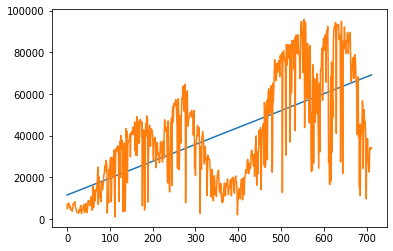

In [37]:
plt.plot(x_train.index, trend_train)

plt.plot(y_train)

## 2021 Trend

In [38]:
x = train_df.drop(['date','rental','year'], axis = 1)
y = train_df['rental']

In [39]:
x

,precipitation,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,days_of_week,month,day,temp_diff,sweat,cold,PCA_temp,PCA_wind
0,0.00000,34.0,17.0,39.1,8.3,86.5,0,1,1,8.9,148.58,-7.14,0.509964,-0.154874
1,0.00000,36.0,22.0,42.0,7.9,82.3,0,1,2,6.1,75.60,-7.74,0.528389,0.005103
2,0.00000,31.0,19.0,42.3,8.6,88.7,0,1,3,6.7,-16.92,-15.62,0.622006,-0.035484
3,0.34462,39.0,24.0,43.0,6.2,63.9,0,1,4,8.0,-30.10,-12.18,0.644993,-0.178941
4,0.00000,51.0,35.0,48.4,8.2,84.5,0,1,5,7.2,77.44,-9.52,0.560958,-0.117122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,0.00000,70.0,42.0,62.9,5.9,61.5,1,12,27,8.6,629.00,2.52,0.276066,-0.163371
1092,1.30000,66.0,44.0,72.1,8.0,83.3,0,12,28,7.2,821.94,5.88,0.215318,-0.211032
1093,0.20000,69.0,46.0,70.8,0.0,0.0,0,12,29,10.5,304.44,-17.98,0.501131,0.298627
1094,0.00000,39.0,15.0,55.5,8.3,86.5,0,12,30,6.7,-344.10,-52.89,0.832072,0.521835


In [40]:
test_df.drop(['year','date'], axis =1)

,precipitation,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,days_of_week,month,day,temp_diff,sweat,cold,PCA_temp,PCA_wind
0,0.000000,30.0,17.0,64.0,6.5,67.7,0,1,1,11.4,102.40,-19.60,0.671528,-0.120388
1,0.000000,34.0,12.0,38.5,9.0,93.8,0,1,2,7.0,-53.90,-21.84,0.699167,0.106168
2,1.867451,39.0,14.0,45.0,5.5,56.7,0,1,3,7.1,-90.00,-18.20,0.722684,-0.085001
3,3.832171,40.0,23.0,51.4,4.6,47.4,0,1,4,8.7,15.42,-14.28,0.660408,-0.255784
4,0.000000,30.0,17.0,52.8,8.6,88.7,0,1,5,7.8,-110.88,-28.71,0.732883,0.188481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,9.800086,33.0,20.0,60.9,3.8,39.6,0,12,27,9.0,-237.51,-21.93,0.818667,-0.264631
361,14.416147,51.0,38.0,73.8,1.7,17.7,0,12,28,7.6,-66.42,-18.70,0.683377,-0.171676
362,14.187274,66.0,49.0,72.9,1.8,18.8,1,12,29,9.7,430.11,-9.88,0.486689,0.150403
363,2.122507,30.0,17.0,48.5,7.3,76.0,1,12,30,7.0,9.70,-22.44,0.646050,0.342468


In [41]:
test_dp = DeterministicProcess(index = x.index, constant = True , order = 1, drop = True)

X = test_dp.in_sample()

lm = LinearRegression(fit_intercept=False)
lm.fit(X, y)

X

,const,trend
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
1091,1.0,1092.0
1092,1.0,1093.0
1093,1.0,1094.0
1094,1.0,1095.0


In [42]:
x_test.index

Int64Index([ 712,  713,  714,  715,  716,  717,  718,  719,  720,  721,
            ...
            1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095],
           dtype='int64', length=384)

In [43]:
test_const = [1 for i in range(test_df.shape[0])]
test_trend = np.arange(X['trend'].max(), X['trend'].max()+test_df.shape[0])
test_trend_squared = [i**2 for i in test_trend]
test_trend_cubed = [i**3 for i in test_trend]
test_trend_4 = [i**4 for i in test_trend]
test_trend_5 = [i**5 for i in test_trend]
test_trend_6 = [i**6 for i in test_trend]



X_ = pd.DataFrame([test_const, test_trend]).T
X_.columns = ['const', 'trend']
X_.index = test_df.index
X_

,const,trend
0,1.0,1096.0
1,1.0,1097.0
2,1.0,1098.0
3,1.0,1099.0
4,1.0,1100.0
...,...,...
360,1.0,1456.0
361,1.0,1457.0
362,1.0,1458.0
363,1.0,1459.0


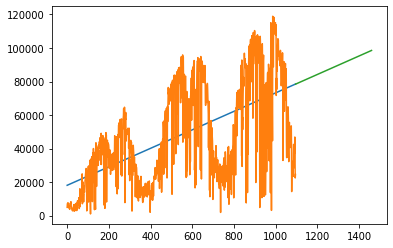

In [44]:
trend_train = lm.predict(X)
trend_test = lm.predict(X_)

plt.plot(x.index, trend_train)
plt.plot(y)
plt.plot(X_.index + len(x.index), trend_test)


y_delta = y / trend_train

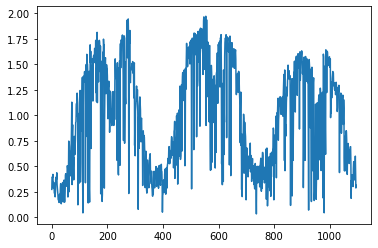

In [45]:
plt.plot(y_delta)

In [46]:
test_df = test_df.drop(['date','year'], axis = 1)

In [47]:
x

,precipitation,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,days_of_week,month,day,temp_diff,sweat,cold,PCA_temp,PCA_wind
0,0.00000,34.0,17.0,39.1,8.3,86.5,0,1,1,8.9,148.58,-7.14,0.509964,-0.154874
1,0.00000,36.0,22.0,42.0,7.9,82.3,0,1,2,6.1,75.60,-7.74,0.528389,0.005103
2,0.00000,31.0,19.0,42.3,8.6,88.7,0,1,3,6.7,-16.92,-15.62,0.622006,-0.035484
3,0.34462,39.0,24.0,43.0,6.2,63.9,0,1,4,8.0,-30.10,-12.18,0.644993,-0.178941
4,0.00000,51.0,35.0,48.4,8.2,84.5,0,1,5,7.2,77.44,-9.52,0.560958,-0.117122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,0.00000,70.0,42.0,62.9,5.9,61.5,1,12,27,8.6,629.00,2.52,0.276066,-0.163371
1092,1.30000,66.0,44.0,72.1,8.0,83.3,0,12,28,7.2,821.94,5.88,0.215318,-0.211032
1093,0.20000,69.0,46.0,70.8,0.0,0.0,0,12,29,10.5,304.44,-17.98,0.501131,0.298627
1094,0.00000,39.0,15.0,55.5,8.3,86.5,0,12,30,6.7,-344.10,-52.89,0.832072,0.521835


In [60]:
test_df.to_csv('open/khs1.csv', index = False)

In [49]:
model1 = GradientBoostingRegressor(n_estimators = 500, max_depth = 3, learning_rate = 0.01)
model1.fit(x, y_delta)

t_pred1 = model1.predict(test_df)
lastpang1 = t_pred1 * trend_test

model2 = RandomForestRegressor(n_estimators = 100)
model2.fit(x, y_delta)

t_pred2 = model2.predict(test_df)
lastpang2 = t_pred2 * trend_test

In [50]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [51]:
test_label = pd.read_excel('open/test_label.xlsx', engine = 'openpyxl')
t_label = test_label['rental']

In [52]:
test_df

,precipitation,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,days_of_week,month,day,temp_diff,sweat,cold,PCA_temp,PCA_wind
0,0.000000,30.0,17.0,64.0,6.5,67.7,0,1,1,11.4,102.40,-19.60,0.671528,-0.120388
1,0.000000,34.0,12.0,38.5,9.0,93.8,0,1,2,7.0,-53.90,-21.84,0.699167,0.106168
2,1.867451,39.0,14.0,45.0,5.5,56.7,0,1,3,7.1,-90.00,-18.20,0.722684,-0.085001
3,3.832171,40.0,23.0,51.4,4.6,47.4,0,1,4,8.7,15.42,-14.28,0.660408,-0.255784
4,0.000000,30.0,17.0,52.8,8.6,88.7,0,1,5,7.8,-110.88,-28.71,0.732883,0.188481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,9.800086,33.0,20.0,60.9,3.8,39.6,0,12,27,9.0,-237.51,-21.93,0.818667,-0.264631
361,14.416147,51.0,38.0,73.8,1.7,17.7,0,12,28,7.6,-66.42,-18.70,0.683377,-0.171676
362,14.187274,66.0,49.0,72.9,1.8,18.8,1,12,29,9.7,430.11,-9.88,0.486689,0.150403
363,2.122507,30.0,17.0,48.5,7.3,76.0,1,12,30,7.0,9.70,-22.44,0.646050,0.342468


In [53]:
model3 = XGBRegressor()
model3.fit(x, y_delta)

t_pred3 = model3.predict(test_df)
lastpang3 = t_pred3 * trend_test

NMAE(t_label, lastpang3)

c:\Users\Admin\anaconda3\envs\KHS_pytorch_v1.8.2\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.26313442365845724

In [54]:
print('GBR = ', NMAE(t_label, lastpang1))
print('RF = ', NMAE(t_label, lastpang2))

GBR =  0.26103661867164635
RF =  0.24996214171009407


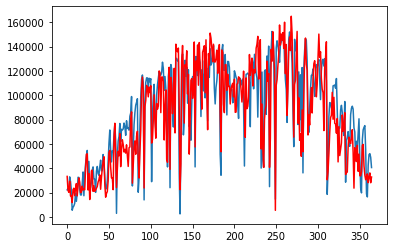

In [55]:
plt.plot(t_label)
plt.plot(lastpang3, 'r')

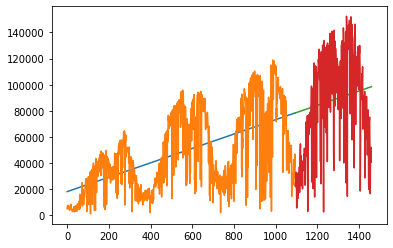

In [56]:
plt.plot(x.index, trend_train)
plt.plot(y)
plt.plot(X_.index + len(x.index), trend_test)
plt.plot(X_.index+1095, t_label)

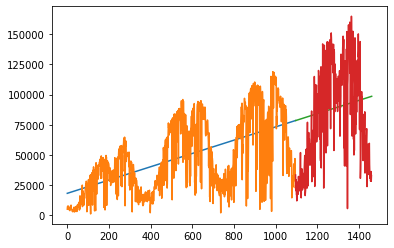

In [57]:
plt.plot(x.index, trend_train)
plt.plot(y)
plt.plot(X_.index + len(x.index), trend_test)
plt.plot(X_.index+1095, lastpang3)

In [58]:
sub_df

,date,rental
0,2021-01-01,0
1,2021-01-02,0
2,2021-01-03,0
3,2021-01-04,0
4,2021-01-05,0
...,...,...
360,2021-12-27,0
361,2021-12-28,0
362,2021-12-29,0
363,2021-12-30,0


In [59]:
for i in range(0, len(lastpang1), 1) :
    sub_df['rental'].loc[i] = lastpang1[i]

sub_df.to_csv('open/submit.csv', index = False)

C:\Users\Admin\AppData\Local\Temp/ipykernel_17000/3626325420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['rental'].loc[i] = lastpang1[i]
